In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from matplotlib import rc
from pylab import rcParams


# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
stopwords = set(stopwords.words('english'))



# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter


%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
data = pd.read_csv('drive/MyDrive/NLP_project/data/train.csv')

In [ ]:
data[data.toxic == 1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


In [ ]:
df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [ ]:
df.shape

(159571, 8)

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
data=df.copy()

In [ ]:
x=data.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=data.iloc[:,2:].sum(axis=1)
data['clean']=(rowsums==0)
#count number of clean entries
data['clean'].sum()
print("Total comments = ",len(data))
print("Total clean comments = ",data['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


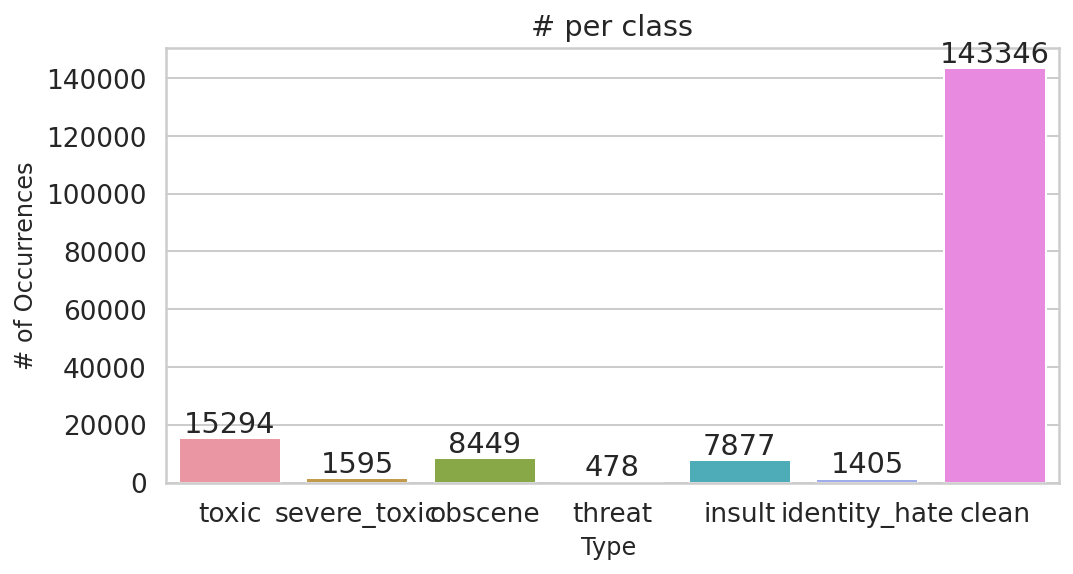

In [ ]:
x=data.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x= x.index, y=x.values)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

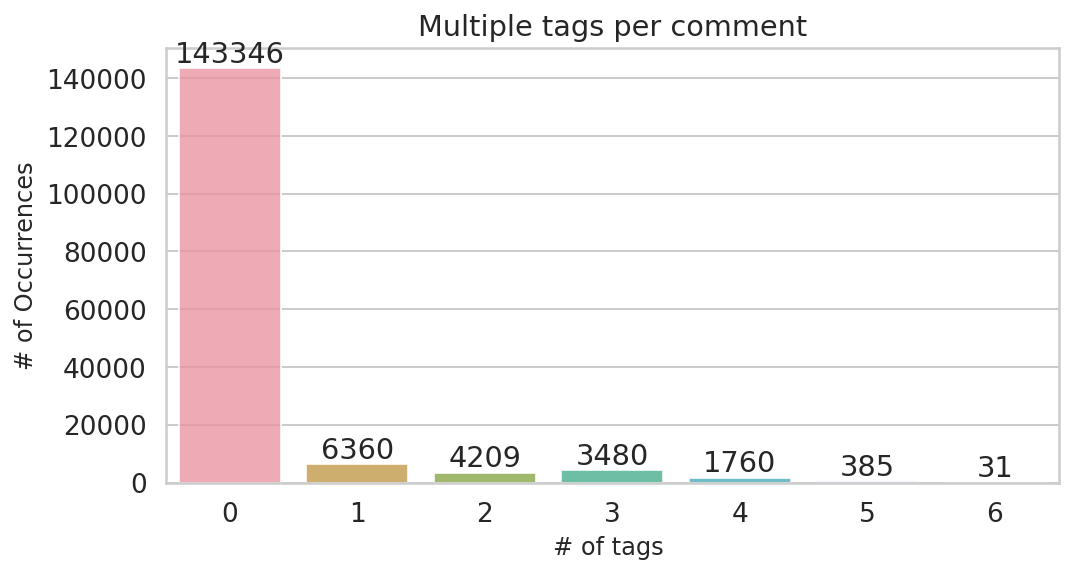

In [ ]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x= x.index, y=x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

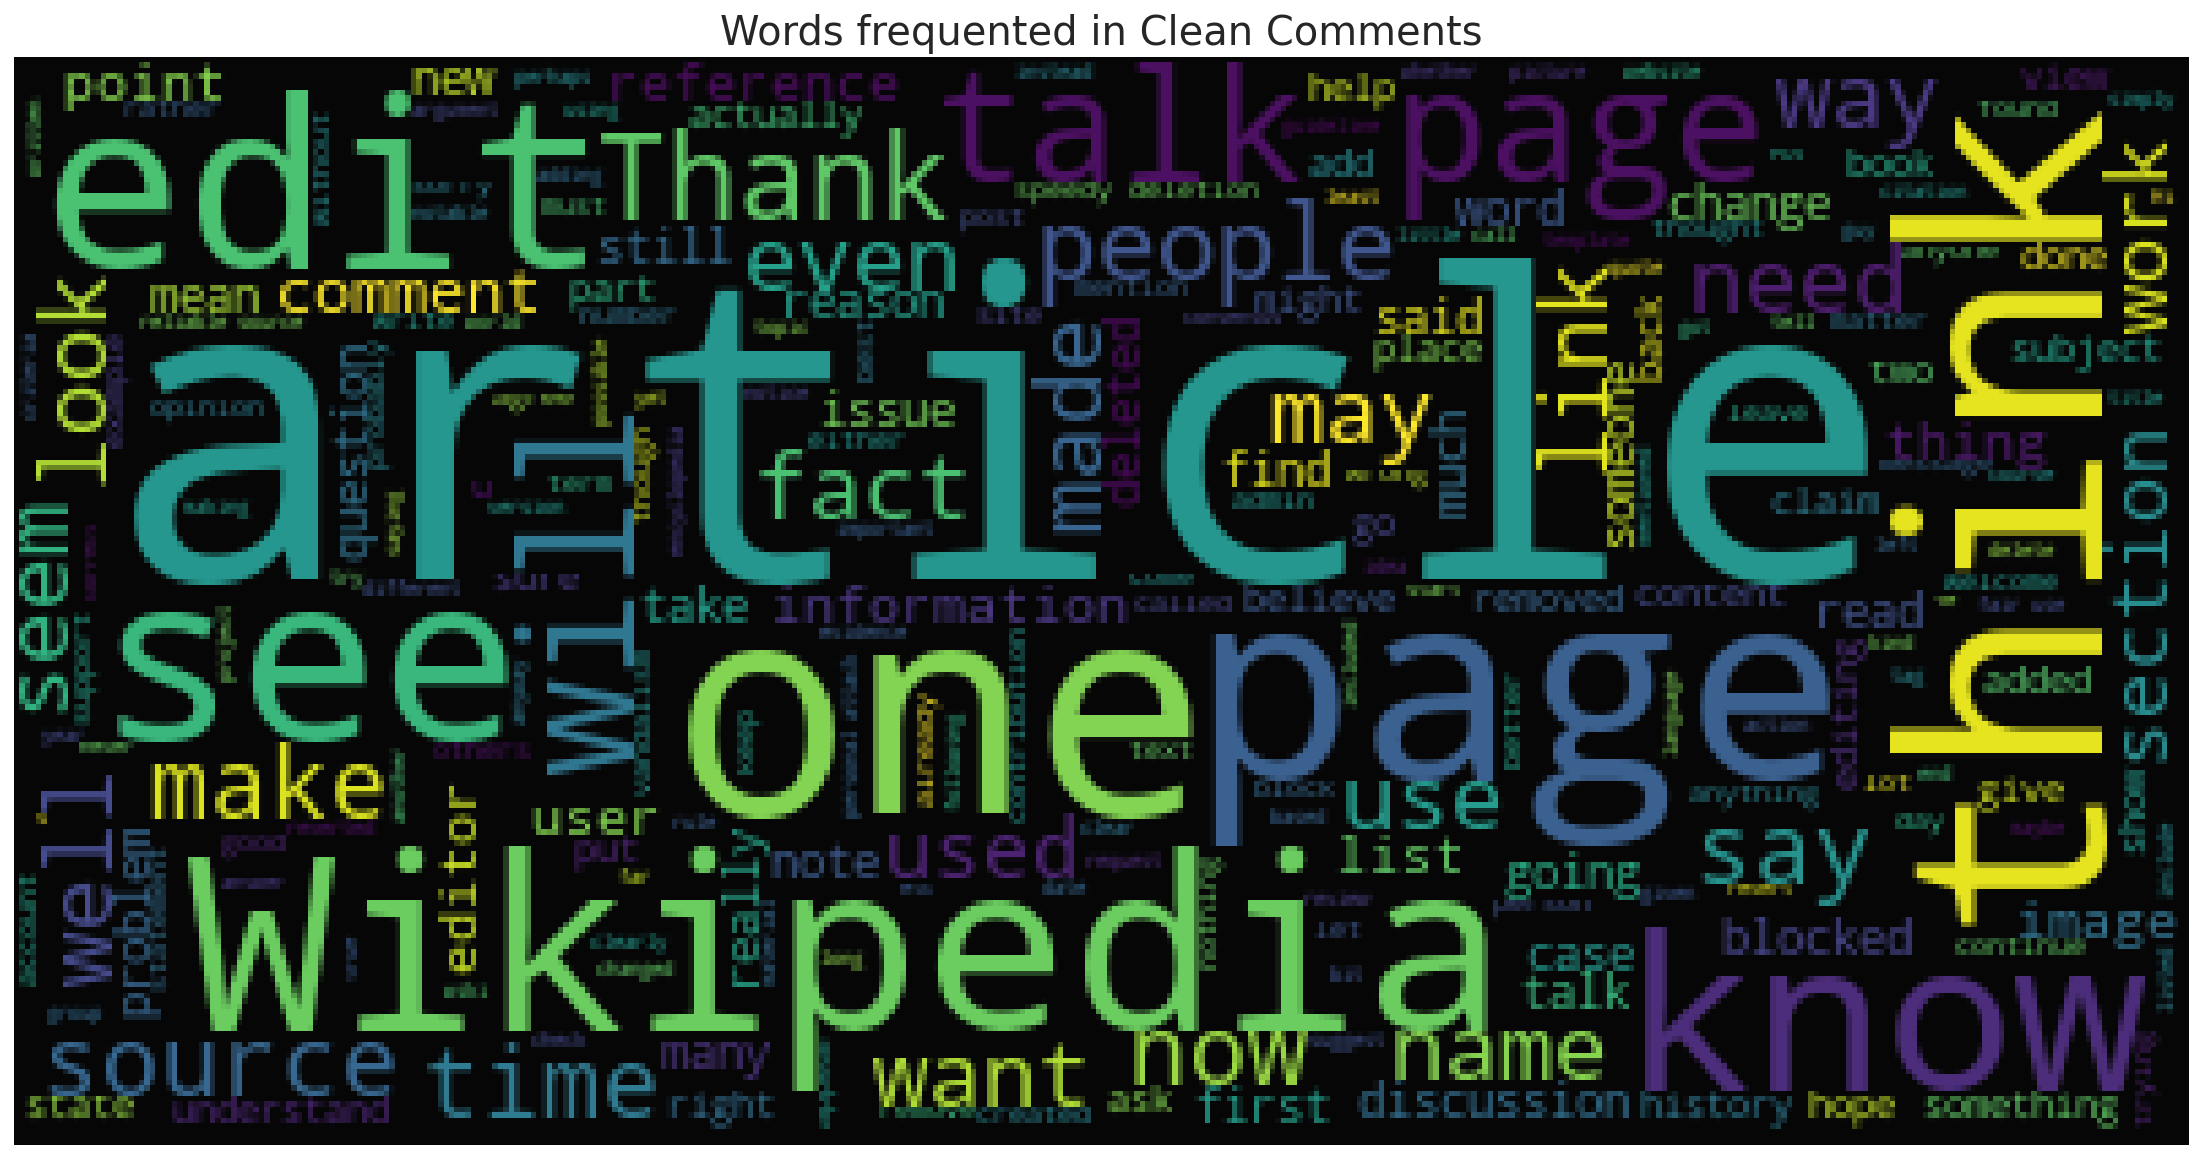

In [ ]:
stopword=set(STOPWORDS)
#wordcloud for clean comments
subset=data[data.clean == True]
text=subset.comment_text.values
wc= WordCloud(background_color="black", max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

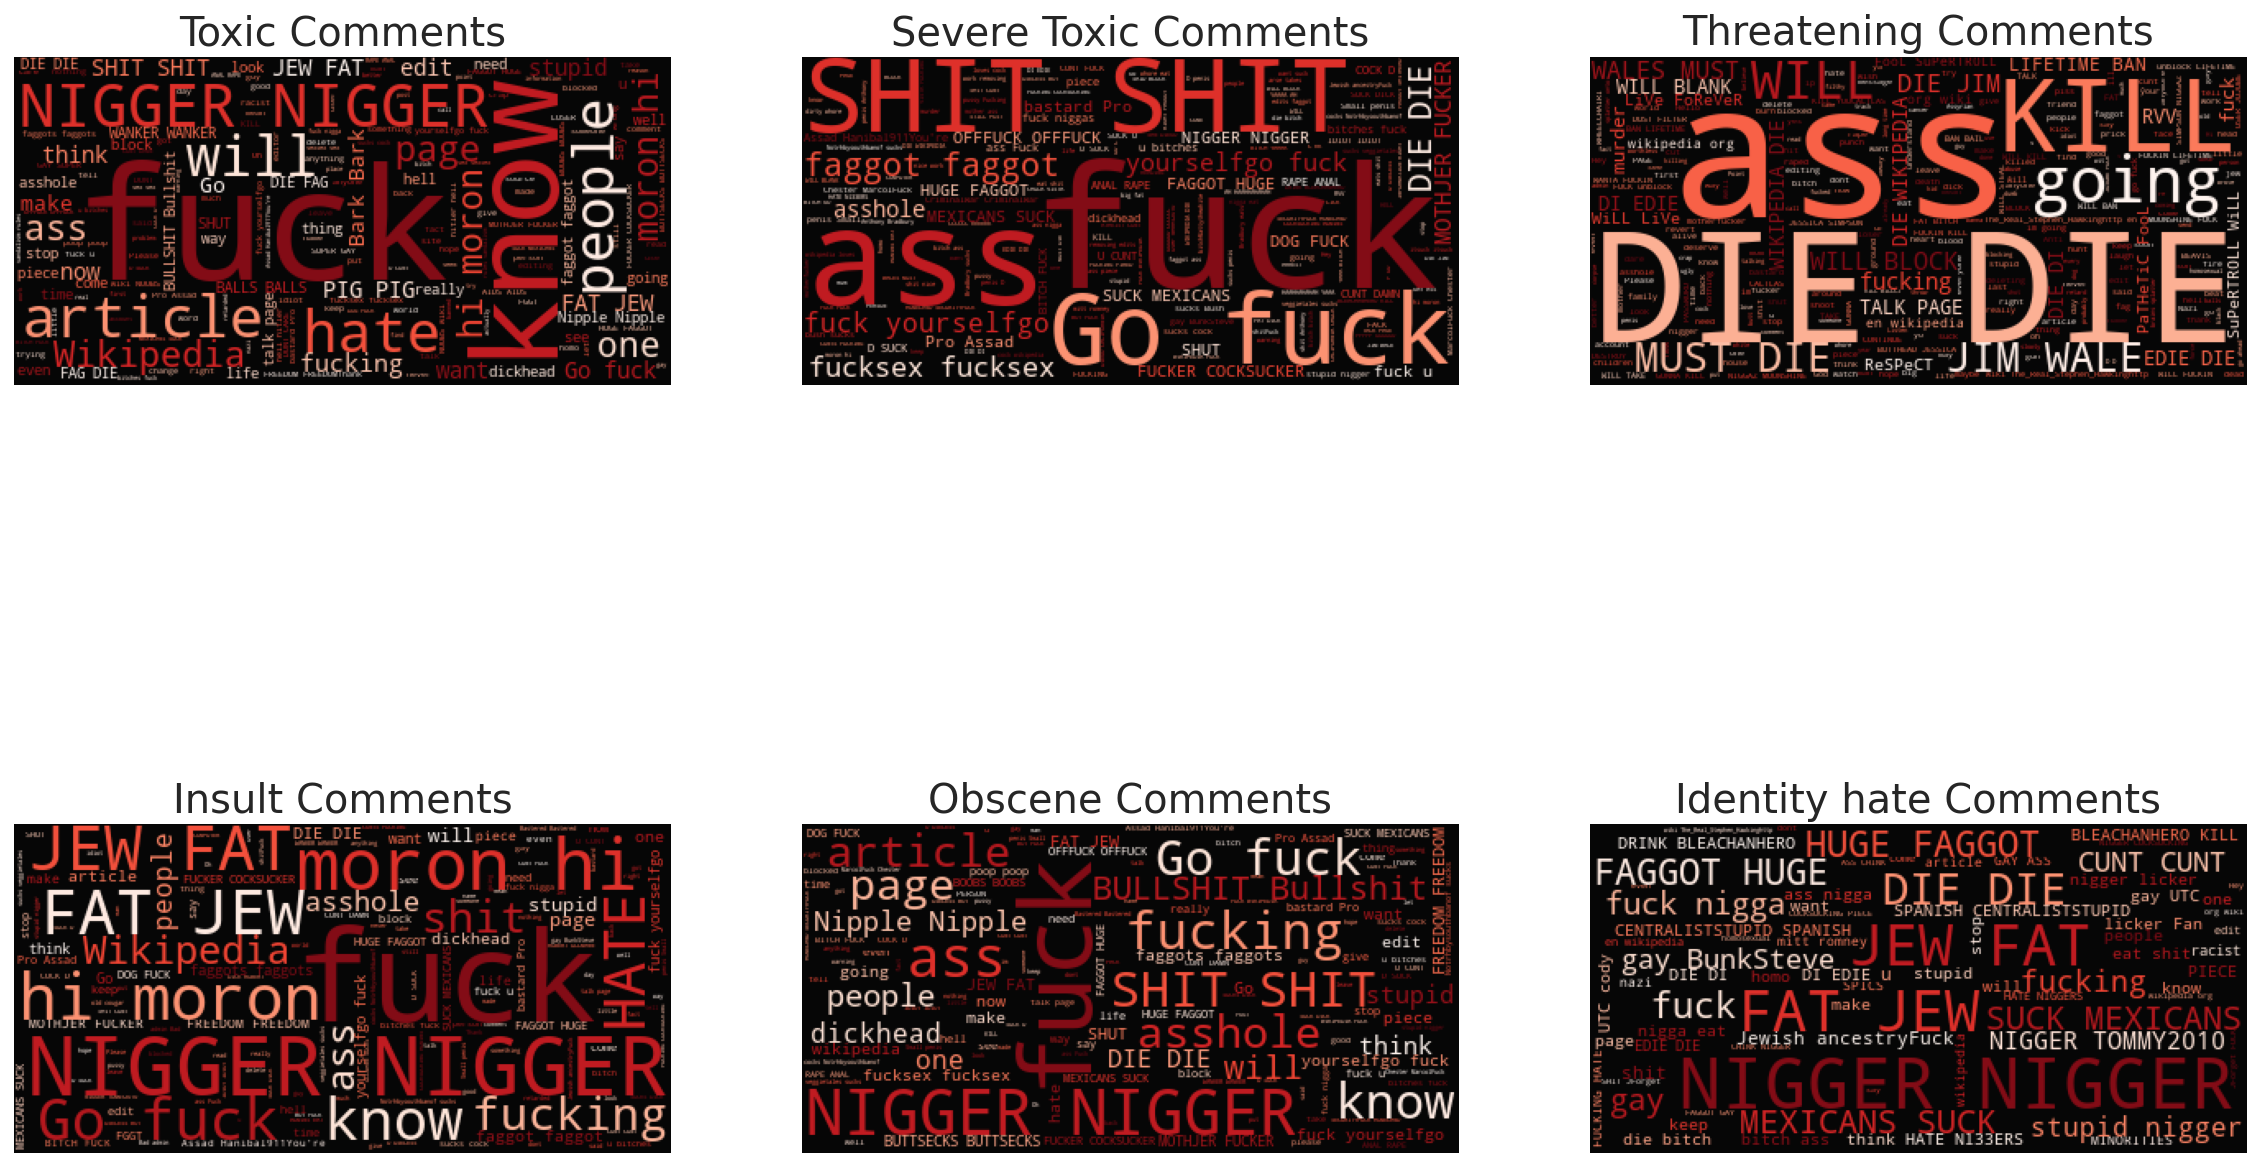

In [ ]:
#Toxic toxic comments
subset=data[data.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(331)
plt.axis("off")
plt.title("Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(332)
subset=data[data.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(333)
subset=data[data.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=2534), alpha=0.98)

#insult
plt.subplot(334)
subset=data[data.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#obscene
plt.subplot(335)
subset=data[data.obscene==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Obscene Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#identity_hate
plt.subplot(336)
subset=data[data.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Identity hate Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

plt.show()

# Tokenize

In [ ]:
data['token_length'] = data.comment_text.progress_apply(lambda x: len(x.split()))

100%|██████████| 159571/159571 [00:03<00:00, 47033.41it/s]


In [ ]:
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,token_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,43
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True,17
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True,42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True,113
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True,13
...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,True,47
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,True,18
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,True,12
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,True,25


In [ ]:
# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)
    
def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces    
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)


def clean_pipeline(text):
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [ ]:
# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [ ]:
data['clean'] = data['comment_text'].progress_apply(clean_pipeline)
data['tokens'] = data['clean'].progress_apply(preprocess_pipeline)
data.head()

100%|██████████| 159571/159571 [01:29<00:00, 1785.25it/s]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,token_length,tokens
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,Explanation\nWhy the edits made under my usern...,43,Explanation Why edits made username Hardcore M...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,D aww He matches this background colour I m se...,17,D aww He match background colour I seemingly s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,Hey man I m really not trying to edit war It s...,42,Hey man I really trying edit war It guy consta...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,\nMore\nI can t make any real suggestions on ...,113,More I make real suggestion improvement I wond...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,You sir are my hero Any chance you remember wh...,13,You sir hero Any chance remember page


In [ ]:
data.iloc[4].tokens[0]

'Y'

In [ ]:
data.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
clean            object
token_length      int64
tokens           object
dtype: object

In [ ]:
a = 6

In [ ]:
data.tokens[a]

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [ ]:
data.comment_text[a]

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [ ]:
data.loc[[a]]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,token_length,tokens
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,8,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK


In [ ]:
data['label'] = list(data.iloc[:,2:8].values)
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,token_length,tokens,label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,Explanation\nWhy the edits made under my usern...,43,Explanation Why edits made username Hardcore M...,"[0, 0, 0, 0, 0, 0]"
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,D aww He matches this background colour I m se...,17,D aww He match background colour I seemingly s...,"[0, 0, 0, 0, 0, 0]"
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,Hey man I m really not trying to edit war It s...,42,Hey man I really trying edit war It guy consta...,"[0, 0, 0, 0, 0, 0]"
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,\nMore\nI can t make any real suggestions on ...,113,More I make real suggestion improvement I wond...,"[0, 0, 0, 0, 0, 0]"
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,You sir are my hero Any chance you remember wh...,13,You sir hero Any chance remember page,"[0, 0, 0, 0, 0, 0]"


(0.0, 512.0)

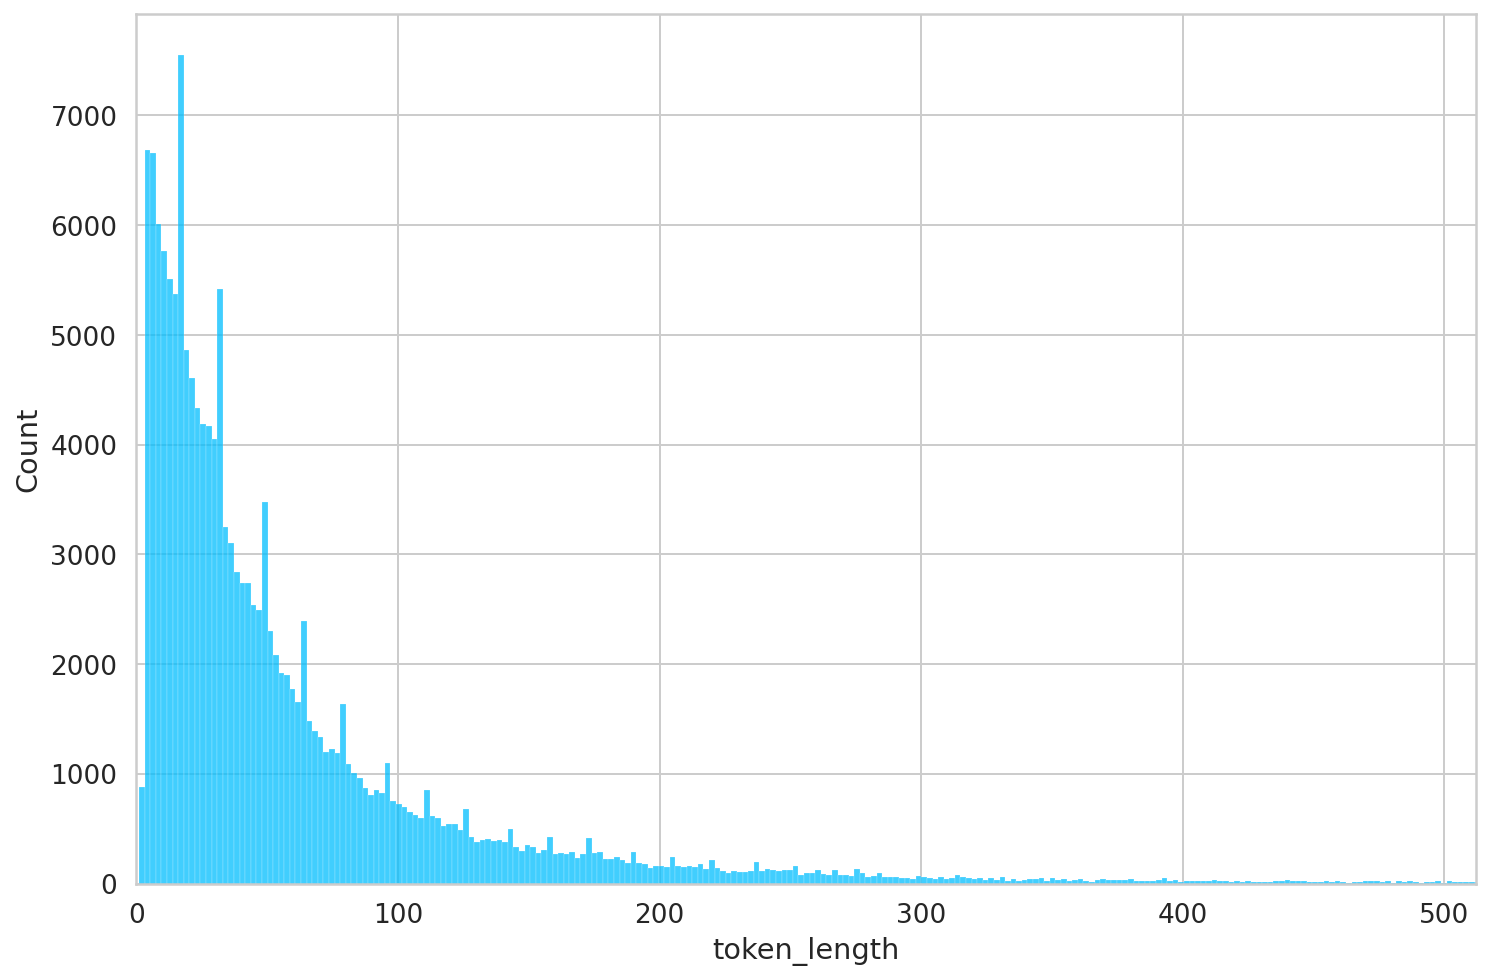

In [ ]:
sns.histplot(data.token_length)
plt.xlim([0, 512])

In [ ]:
# data[['tokens', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_csv(
#     './drive/MyDrive/NLP_project/tokenized.csv', index=False, header=True)

In [ ]:
data.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
clean            object
token_length      int64
tokens           object
label            object
dtype: object